In [65]:
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier

In [38]:
mnist = fetch_mldata('MNIST original')

In [39]:
mnist.data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [6]:
X,y = mnist.data, mnist.target

In [7]:
some_digit = X[36000]

In [8]:
some_digit_image = some_digit.reshape(28,28)

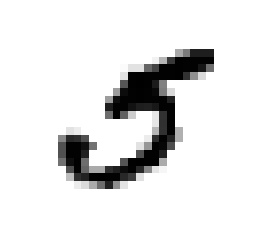

In [9]:
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [10]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [11]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_5)
sgd_clf.predict([some_digit])


array([ True], dtype=bool)

In [18]:
skfolds = StratifiedKFold(n_splits=3 , random_state=42)

In [25]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(float(n_correct) / len(y_pred))

0.96525
0.9535
0.96405


In [28]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,scoring="accuracy")

array([ 0.96525,  0.9535 ,  0.96405])

In [31]:
class Never5Classifier(BaseEstimator): 
    def fit(self, X, y=None):
        pass 
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

In [33]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9084 ,  0.90975,  0.9108 ])

In [45]:
y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3)
confusion_matrix(y_train_5,y_train_pred)

array([[53582,   997],
       [ 1347,  4074]])

In [50]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores 
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [51]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=4, method="decision_function")

In [53]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

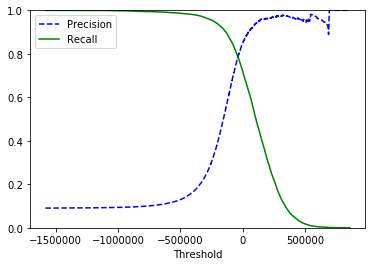

In [58]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

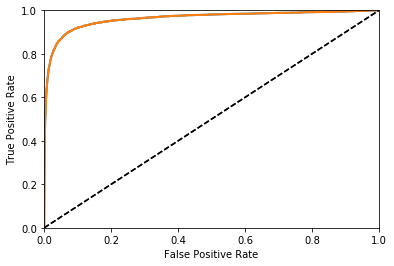

In [64]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) 

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis(([0,1,0,1]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr,tpr)
plt.show()

In [66]:
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

/Users/sambvani/anaconda/lib/python2.7/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  six.iterkeys(self.codes))))


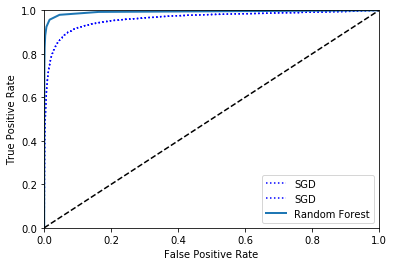

In [72]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr,tpr,'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()
